In [1]:
from setup import *
from utils import *

In [4]:
# Create the dictionary of materials to use for the render.
# We can simulate the chamber with and without the fluids (CF4 and LAr).
materials = create_materials(with_fluids=True)

# Load in the scene components and assign them the materials.
# Here, we can choose whether or not we want to use the distorted jar surface 
# and choose whether we want to simulate the SNOLAB chamber 
#   (which effectively changes the viewport/camera positions and pressure vessel)
components = load_components(materials=materials, use_distorted_jar=True)

# Choose which of the three cameras to render from and the sample count for the render
sensor = create_sensor(sensor_number=2, sample_count=1024)

# Put the scene together into one large dictionary which 
# will be passed into the render function
scene = load_scene(components=components, sensor=sensor)
# scene = load_scene(components=components, sensor=sensor, integrator={'type': 'path', 'max_depth': 4}) # render this to see direct illumination surfaces

# Note: you can ignore the warnings about 'unknown element "edge"'

2024-08-14 16:51:22 WARN main [PLYMesh] "outer_jar_outer_surface_top_distorted.ply": skipping unknown element "edge"

2024-08-14 16:51:22 WARN main [PLYMesh] "outer_jar_inner_surface_top_distorted.ply": skipping unknown element "edge"

2024-08-14 16:51:22 WARN main [PLYMesh] "inner_jar_outer_surface_bottom.ply": skipping unknown element "edge"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved Image: ./outputs/2024_08_14/16_51_28_mono.png
Saved Image: ./outputs/2024_08_14/16_51_28_rgb.png


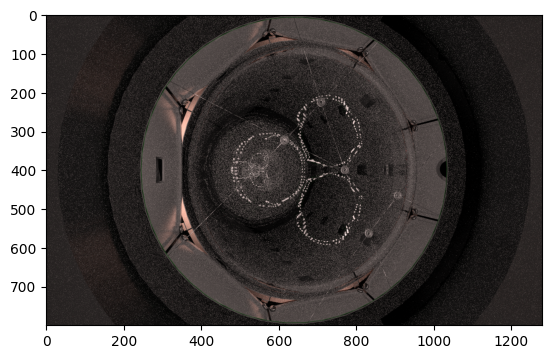

In [5]:
# Finally, we can render the scene. Setting denoise to True uses
# NVIDIA Optix to denoise the rendered image. This is not recommended for renders
# with a low sample count, as denoising a very noisy image can produce worse results.
# However, denoising can be useful for things like Hough Circle detection since it can
# more clearly define the edges of scene objects.
image = render(scene=scene, denoise=False, save_mono=True, save_rgb=True)

# Show the image
# mi.Bitmap(image)
plt.imshow(image**(1/2.2)) # note that **(1/2.2) is applying a gamma correction to the image! 
# (The gamma correcitons are pre-applied when we save the images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved Image: ./outputs/2024_08_14/16_51_52_mono.png
Saved Image: ./outputs/2024_08_14/16_51_52_rgb.png


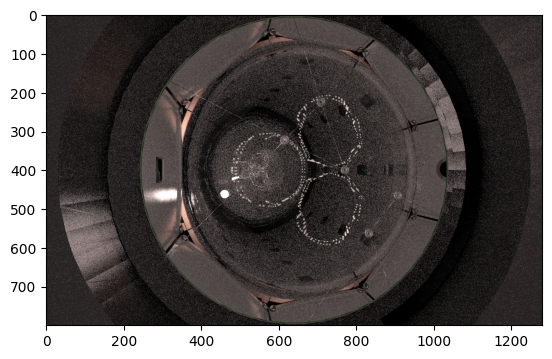

In [6]:
# We can add a bubble to the scene by updating the components dictionary.

location = np.array([8.0, 3.0, -14.0]) # Set the location in cm. Note that the jar is along -z!
scale = 0.5 # radius of the bubble in cm
light = True # should the bubble be emissive or a normal bubble?

if light:
    # For the remapping and triangulation tests, the bubbles are sometimes 
    # replaced with lights to make localizing their pixel positions easier.
    components.update({
        'bubble': mi.load_dict({
            'type': 'sphere',
            'focused-emitter': { # Define the properties of the light...
                'type':'area',
                'radiance': {
                    'type': 'spectrum',
                    'value': 60.0
                },
            },
            'to_world': mi.ScalarTransform4f.translate(location).scale(scale),
        })
    })
else:
    # We could also make the bubble an actual bubble with an interior IoR of 1.0:
    components.update({
        'bubble': mi.load_dict({
            'type': 'sphere',
            'bsdf': {
                'type': 'dielectric',
                'int_ior': 1.0, # IoR of a vacuum
                'ext_ior': 1.17, # IoR of LAr
            },
            'to_world': mi.ScalarTransform4f.translate(location).scale(scale),
        })
    })

# Reload the scene and render again
scene = load_scene(components=components, sensor=sensor)
image_w_bubble = render(scene=scene, denoise=False, save_mono=True, save_rgb=True)
# mi.Bitmap(image_w_bubble)
plt.imshow(image_w_bubble**(1/2.2))